In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation,
                                     RandomContrast, Resizing, Rescaling)
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import  SparseCategoricalAccuracy, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import L2
from tensorflow.train import BytesList, FloatList, Int64List, Example, Features, Feature
from Emotion_Detector.utils.model_store import ResNet34
import tensorflow_probability as tfp
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
TRAIN_DIRECTORY =  "C:/Datasets/fer2013/train"
VAL_DIRECTORY = "C:/Datasets/fer2013/test"
CLASS_NAMES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

CONFUGURATIONS = {
    'BATCH_SIZE' : 32,
    'IM_SIZE' : 256,
    'LEARNING_RATE' : 0.001,
    'EPOCHS' : 5,
    'DROPOUT_RATE' : 0.0,
    'REGULARIZATION_RATE' : 0.0,
    'N_FILTERS' : 6,
    'KERNAL_SIZE' : 3,
    'N_STRIDES' : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 100,
    "N_DENSE_2": 10,
    'NUM_CLASSES': 7
}

In [24]:
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    labels='inferred', ## consider file as class
    label_mode='categorical', ## factorized classes
    class_names=CLASS_NAMES, ## Defined class name as per subdirectories
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=22
)

Found 28709 files belonging to 7 classes.


In [25]:
val_data = tf.keras.utils.image_dataset_from_directory(
    VAL_DIRECTORY,
    labels='inferred', ## consider file as class
    label_mode='categorical', ## factorized classes
    class_names=CLASS_NAMES, ## Defined class name as per subdirectories
    color_mode='rgb',
    batch_size=CONFUGURATIONS['BATCH_SIZE'],
    image_size=(CONFUGURATIONS['IM_SIZE'], CONFUGURATIONS['IM_SIZE']),
    shuffle=True,
    seed=22
)

Found 7178 files belonging to 7 classes.


In [26]:
for image in train_data.take(1):
    print(image)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[163., 163., 163.],
         [163., 163., 163.],
         [163., 163., 163.],
         ...,
         [164., 164., 164.],
         [164., 164., 164.],
         [164., 164., 164.]],

        [[163., 163., 163.],
         [163., 163., 163.],
         [163., 163., 163.],
         ...,
         [164., 164., 164.],
         [164., 164., 164.],
         [164., 164., 164.]],

        [[163., 163., 163.],
         [163., 163., 163.],
         [163., 163., 163.],
         ...,
         [164., 164., 164.],
         [164., 164., 164.],
         [164., 164., 164.]],

        ...,

        [[211., 211., 211.],
         [211., 211., 211.],
         [211., 211., 211.],
         ...,
         [158., 158., 158.],
         [158., 158., 158.],
         [158., 158., 158.]],

        [[211., 211., 211.],
         [211., 211., 211.],
         [211., 211., 211.],
         ...,
         [158., 158., 158.],
         [158., 158., 158.],
       

#### **DATA VISUALIZATION**

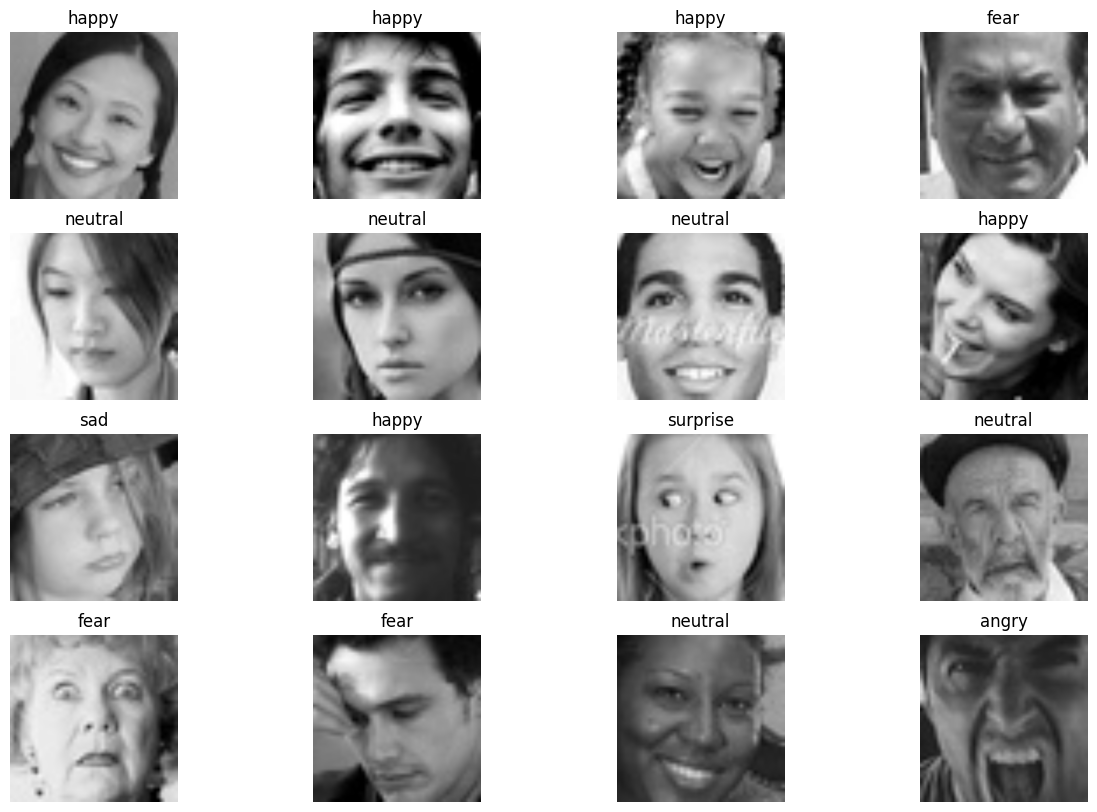

In [27]:
plt.figure(figsize=(15,10))
for images,labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis = 0).numpy()])
        plt.axis("off")

#### **DATASET AUGMENTATION**

In [4]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1)
])

In [5]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

#### **CUTMIX AUGUMENTATION**

In [10]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFUGURATIONS["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFUGURATIONS["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFUGURATIONS["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFUGURATIONS["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFUGURATIONS["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFUGURATIONS["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFUGURATIONS["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFUGURATIONS["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [11]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFUGURATIONS["IM_SIZE"], CONFUGURATIONS["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFUGURATIONS["IM_SIZE"], CONFUGURATIONS["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFUGURATIONS["IM_SIZE"]*CONFUGURATIONS["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

#### **DATASET PREPARATION**

In [11]:
train_dataset_1 = train_data.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_data.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [30]:
train_data = (
    train_data.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)#.prefetch(tf.data.AUTOTUNE)
)

In [31]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [14]:
# train_data = (
#     mixed_dataset.map(cutmix, 
#                       num_parallel_calls=tf.data.AUTOTUNE)#.prefetch(tf.data.AUTOTUNE)
# )

In [15]:
# val_data = (
#     val_data.prefetch(tf.data.AUTOTUNE)
# )

In [6]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFUGURATIONS['IM_SIZE'], CONFUGURATIONS['IM_SIZE']),
    Rescaling(1./255)
])

#### **TF RECORDS**

In [14]:
## Unbaching the training data for creating tensorflow records
train_data = (
    train_data.unbatch()
)

In [15]:
## Unbaching the validation data for creating tensorflow records
# val_data = (
#     val_data.unbatch()
# )

In [16]:
train_data

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>

In [17]:
## Serializing the image as bytes feature
def create_example(image, label):

    bytes_feature = Feature(
        bytes_list=BytesList(value=[image]))

    int_feature = Feature(
        int64_list=Int64List(value=[label]))

    example = tf.train.Example(
        features=Features(feature={
            'images': bytes_feature,
            'labels': int_feature,
        }))
    
    return example.SerializeToString()

In [7]:
## Number of shards and tfrecord path
TRAIN_NUM_SHARDS = 10
TEST_NUM_SHARDS = 5
TRAIN_RECORDS_PATH = 'artifacts/data_preprocessing/train_tfrecords/shard_{:02d}.tfrecord'
TEST_RECORDS_PATH = 'artifacts/data_preprocessing/test_tfrecords/shard_{:02d}.tfrecord'

In [19]:
## Encoding the image as byte
def image_to_byte_encoder(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, tf.argmax(label)

In [20]:
## Encoding training images into bytes
encoded_data = (
    train_data.map(image_to_byte_encoder)
)

In [ ]:
## Creating tf records for the training data
for shard_number in range(NUM_SHARDS):
    sharded_data = (
        encoded_data.shard(NUM_SHARDS, shard_number).as_numpy_iterator()
    )

    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in sharded_data:
            example = create_example(encoded_image, encoded_label)
            file_writer.write(example)

In [8]:
import os
os.chdir('../')

In [9]:
## Recostructing the dataset
recons_train_data = tf.data.TFRecordDataset(filenames= [TRAIN_RECORDS_PATH.format(p)  for p in range(TRAIN_NUM_SHARDS)])
recons_test_data = tf.data.TFRecordDataset(filenames= [TEST_RECORDS_PATH.format(p)  for p in range(TEST_NUM_SHARDS)])

In [7]:
[TRAIN_RECORDS_PATH.format(p)  for p in range(TRAIN_NUM_SHARDS)]

['artifacts/data_preprocessing/train_tfrecords/shard_00.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_01.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_02.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_03.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_04.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_05.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_06.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_07.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_08.tfrecord',
 'artifacts/data_preprocessing/train_tfrecords/shard_09.tfrecord']

In [10]:
def parse_tfrecords(example):

    feature_description = {
        "images" : tf.io.FixedLenFeature([], tf.string),
        "labels" : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example['images'] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [11]:
parsed_train_data = (recons_train_data.map(parse_tfrecords).batch(CONFUGURATIONS["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE))
parsed_test_data = (recons_test_data.map(parse_tfrecords).batch(CONFUGURATIONS["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE))

In [12]:
parsed_train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [11]:
for i, labels in parsed_test_data.take(1):
    print(i)

tf.Tensor(
[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.6784314  0.6784314  0.6784314 ]
   [0.7058824  0.7058824  0.7058824 ]
   [0.69411767 0.69411767 0.69411767]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.9960785  0.9960785  0.9960785 ]
   ...
   [0.68235296 0.68235296 0.68235296]
   [0.654902   0.654902   0.654902  ]
   [0.6745098  0.6745098  0.6745098 ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.69411767 0.69411767 0.69411767]
   [0.6901961  0.6901961  0.6901961 ]
   [0.70980394 0.70980394 0.70980394]]

  ...

  [[0.7803922  0.7803922  0.7803922 ]
   [0.7411765  0.7411765  0.7411765 ]
   [0.7607844  0.7607844  0.7607844 ]
   ...
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.7725491  0.7725491  0.772549

#### **MODEL CREATION**

In [17]:
model = tf.keras.Sequential([
    InputLayer(input_shape =(None, None, 3)),
    resize_rescale_layer,
    
    Conv2D(filters = CONFUGURATIONS['N_FILTERS'], kernel_size = CONFUGURATIONS['KERNAL_SIZE'], strides = CONFUGURATIONS['N_STRIDES'], 
           padding = 'valid', activation = 'relu', kernel_regularizer =L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFUGURATIONS['POOL_SIZE'], strides = CONFUGURATIONS['N_STRIDES']*2),
    Dropout(rate = CONFUGURATIONS['DROPOUT_RATE']),

    Conv2D(filters = CONFUGURATIONS['N_FILTERS']*2 + 4, kernel_size = CONFUGURATIONS['KERNAL_SIZE'], strides = CONFUGURATIONS['N_STRIDES'], 
           padding = 'valid', activation = 'relu', kernel_regularizer =L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFUGURATIONS['POOL_SIZE'], strides = CONFUGURATIONS['N_STRIDES']*2),

    Flatten(),

    Dense(CONFUGURATIONS['N_DENSE_1'], activation = 'relu', kernel_regularizer = L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(CONFUGURATIONS['N_DENSE_2'], activation = 'relu', kernel_regularizer = L2(CONFUGURATIONS['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = CONFUGURATIONS['DROPOUT_RATE']),

    Dense(CONFUGURATIONS['NUM_CLASSES'], activation = 'softmax')
    
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [13]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.downsample = downsample
        self.strides = strides

    def call(self, inputs, training=None):
        identity = inputs

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        if self.downsample is not None:
            identity = self.downsample(inputs)

        x += identity
        x = self.relu(x)
        return x


class ResNet34(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
        
        self.layer1 = self.build_resnet_block(64, blocks=3)
        self.layer2 = self.build_resnet_block(128, blocks=4, strides=2)
        self.layer3 = self.build_resnet_block(256, blocks=6, strides=2)
        self.layer4 = self.build_resnet_block(512, blocks=3, strides=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def build_resnet_block(self, filters, blocks, strides=1):
        downsample = None
        if strides != 1 or filters != 64:
            downsample = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), strides=strides),
                tf.keras.layers.BatchNormalization()
            ])

        layers = []
        layers.append(ResidualBlock(filters, strides, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(filters))

        return tf.keras.Sequential(layers)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        x = self.avgpool(x)
        x = self.fc(x)
        return x

In [44]:
from Emotion_Detector.utils.model_store import ResNet34

In [45]:
resnet34_model = ResNet34()

In [47]:
resnet34_model.build([1,256,256,3])

In [48]:
resnet34_model.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

In [57]:
checkpoint_callback = ModelCheckpoint(
    'best_weights', 
    monitor='val_accuracy',
    mode = 'max',
    verbose=1, 
    save_best_only=True,
    )

In [58]:
loss_function = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy(name = 'accuracy'), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]
resnet34_model.compile(
    optimizer = Adam(learning_rate = 0.001*10),
    loss = loss_function,
    metrics = metrics)

In [59]:
history = resnet34_model.fit(
    parsed_train_data,
    validation_data= parsed_test_data,
    epochs = 20,
    verbose = 1,
    batch_size = 32,
    callbacks=[checkpoint_callback]
)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'resnet_34/res_block/custom_conv2d/conv2d_239/Relu' defined at (most recent call last):
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\base_events.py", line 539, in run_forever
      self._run_once()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\base_events.py", line 1775, in _run_once
      handle._run()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sv255\AppData\Local\Temp\ipykernel_3216\4147553647.py", line 7, in <module>
      callbacks=[checkpoint_callback]
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\DS_Projects\Human-Emotion-Detection-CNN\src\Emotion_Detector\utils\model_store.py", line 165, in call
      x = self.conv_4_4(x, training)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\DS_Projects\Human-Emotion-Detection-CNN\src\Emotion_Detector\utils\model_store.py", line 105, in call
      x = self.custom_conv_1(input, training)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\DS_Projects\Human-Emotion-Detection-CNN\src\Emotion_Detector\utils\model_store.py", line 84, in call
      x = self.conv(x)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\activations.py", line 318, in relu
      x, alpha=alpha, max_value=max_value, threshold=threshold
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'resnet_34/res_block/custom_conv2d/conv2d_239/Relu'
OOM when allocating tensor with shape[256,256,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node resnet_34/res_block/custom_conv2d/conv2d_239/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_32574]

#### **TRAINING**

In [18]:
loss_function = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy(name = "accuracy")]

In [19]:
model.compile(
    optimizer = Adam(learning_rate= CONFUGURATIONS['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [20]:
history = model.fit(
    parsed_test_data,
    epochs=CONFUGURATIONS["EPOCHS"],
    verbose = 1
)

Epoch 1/5


NotFoundError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\base_events.py", line 539, in run_forever
      self._run_once()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\base_events.py", line 1775, in _run_once
      handle._run()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sv255\AppData\Local\Temp\ipykernel_6864\2571500440.py", line 4, in <module>
      verbose = 1
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\base_events.py", line 539, in run_forever
      self._run_once()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\base_events.py", line 1775, in _run_once
      handle._run()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sv255\AppData\Local\Temp\ipykernel_6864\2571500440.py", line 4, in <module>
      verbose = 1
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\sv255\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) NOT_FOUND:  NewRandomAccessFile failed to Create/Open: artifacts/data_preprocessing/test_tfrecords/shard_00.tfrecord : The system cannot find the path specified.
; No such process
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
  (1) NOT_FOUND:  NewRandomAccessFile failed to Create/Open: artifacts/data_preprocessing/test_tfrecords/shard_00.tfrecord : The system cannot find the path specified.
; No such process
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1857]

#### **MODEL PERFORMANCE**

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

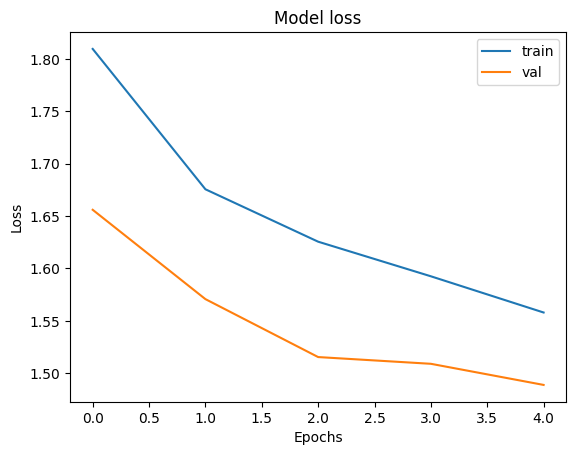

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

#### **MODEL EVALUATION**

In [ ]:
model.evaluate(val_data)

225/225 [==============================] - 9s 38ms/step - loss: 1.4889 - accuracy: 0.4273 - top_k_accuracy: 0.6159


[1.4888783693313599, 0.4272778034210205, 0.6159096956253052]

#### **TESTING**

In [ ]:
test_image = cv2.imread("C:/Datasets/fer2013/train/happy/Training_164916.jpg")
im = tf.constant(test_image, dtype = tf.float32)
print(im.shape)

(48, 48, 3)


In [ ]:
im = tf.expand_dims(im, axis = 0)

In [ ]:
CLASS_NAMES[tf.argmax(model(im), axis = -1).numpy()[0]]

'happy'

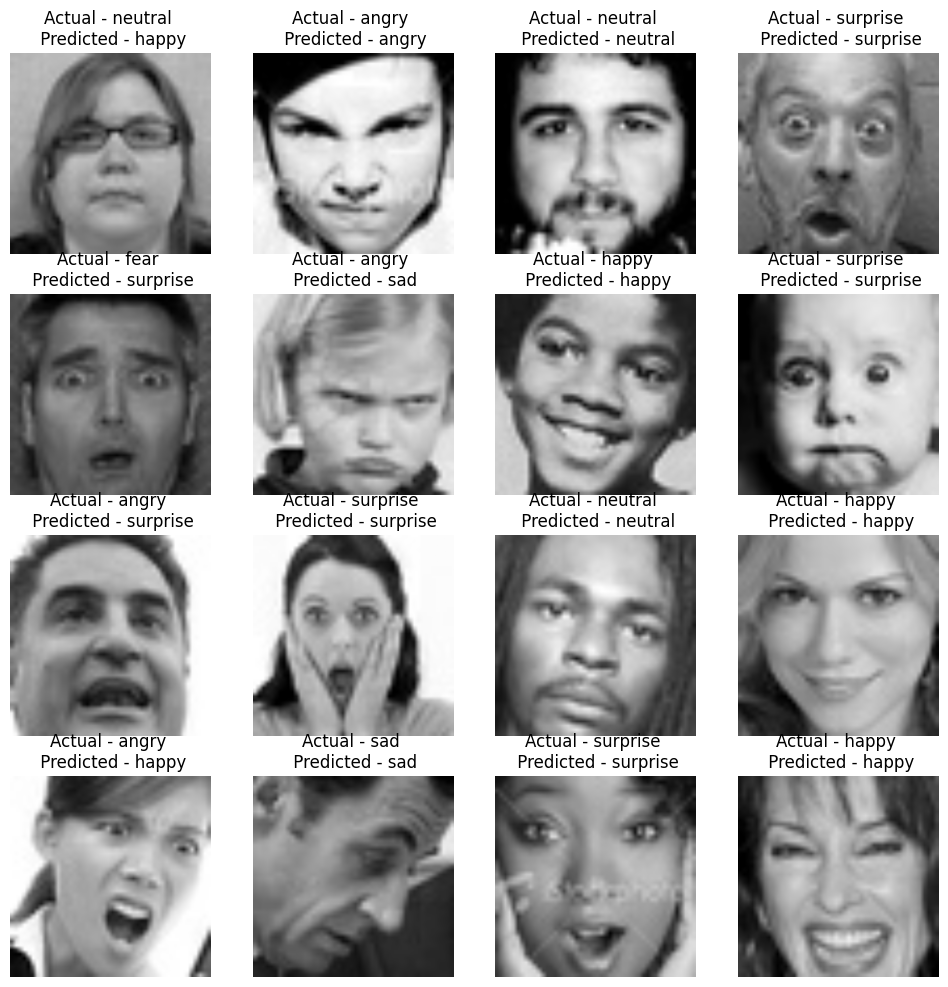

In [ ]:
plt.figure(figsize=(12,12))
for images, labels in val_data.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(f"Actual - {CLASS_NAMES[tf.argmax(labels[i],axis = 0).numpy()]} \n Predicted - {CLASS_NAMES[tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]}")
        plt.axis('off')

#### **CONFUSION MATRIX**

In [ ]:
labels = []
predicted = []
for image, label in val_data:
    labels.append(label.numpy())
    predicted.append(model(image))

In [ ]:
actual = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
predicted = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

In [ ]:
len(predicted)

7178

[[ 144    0   77  260  184  174  119]
 [  28    0   12   32   18   13    8]
 [  68    0  123  248  194  156  235]
 [  50    0   55 1329  132  121   87]
 [  62    0   55  310  520  167  119]
 [ 103    0   94  317  247  381  105]
 [  19    0   38  101   60   43  570]]


Text(0.5, 58.7222222222222, 'Predicted')

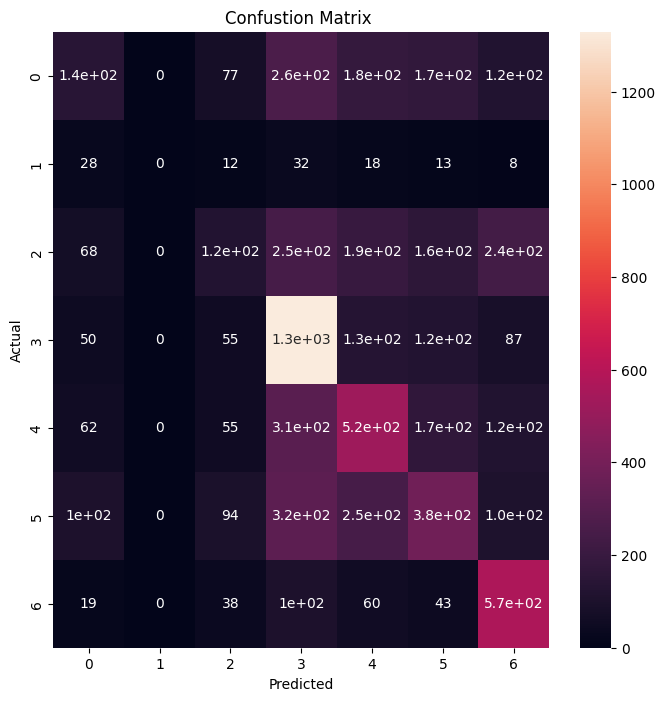

In [ ]:
cm = confusion_matrix(actual, predicted)
print(cm)

plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True)
plt.title("Confustion Matrix ")
plt.ylabel('Actual')
plt.xlabel('Predicted')


In [ ]:
model.save('fer13_model.h5')

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
import os
os.chdir('../')
os.listdir('artifacts/data_preprocessing/train_tfrecords')

['shard_00.tfrecord',
 'shard_01.tfrecord',
 'shard_02.tfrecord',
 'shard_03.tfrecord',
 'shard_04.tfrecord',
 'shard_05.tfrecord',
 'shard_06.tfrecord',
 'shard_07.tfrecord',
 'shard_08.tfrecord',
 'shard_09.tfrecord']